In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os

all_files = glob("/kaggle/input/study-exports/*.csv", recursive=True) 
df_list = [pd.read_csv(filename) for filename in all_files]

if df_list:
    df = pd.concat(df_list, ignore_index=True)
else:
    raise FileNotFoundError("No CSV files found to merge.")

df["Date"] = pd.to_datetime(df["Date"])
df["Duration_hours"] = pd.to_timedelta(df["Duration"]).dt.total_seconds() / 3600
df["Weekday"] = df["Date"].dt.day_name()
df["Month"] = df["Date"].dt.to_period("M").astype(str)

plt.style.use('ggplot')

In [2]:
# Aggregate total study hours per course
course_hours = df.groupby("Project name")["Duration_hours"].sum().reset_index()
course_hours = course_hours.rename(columns={"Duration_hours": "Total Study Hours (Hours)"})
course_hours = course_hours.sort_values(by='Total Study Hours (Hours)', ascending=False)

# Display as markdown in notebook
print("--- Total Study Hours per Project/Course ---")
print(course_hours.round(2).to_markdown(index=False, numalign="left", stralign="left"))

# Save table as Markdown for report
report_dir = "study_report"
os.makedirs(report_dir, exist_ok=True)
course_hours_md_path = os.path.join(report_dir, "course_hours.md")

with open(course_hours_md_path, "w") as f:
    f.write("## Total Study Hours per Project/Course\n\n")
    f.write(course_hours.round(2).to_markdown(index=False, numalign="left", stralign="left"))
    f.write("\n")

--- Total Study Hours per Project/Course ---
| Project name                | Total Study Hours (Hours)   |
|:----------------------------|:----------------------------|
| Deep Learning for Beginners | 5.62                        |
| Computational MRI           | 4.06                        |
| A1.2                        | 3.2                         |
| Algorithmic Bioinformatics  | 1.83                        |
| English                     | 0.67                        |


In [3]:
# Create complete date range
all_dates = pd.DataFrame({"Date": pd.date_range(df["Date"].min(), df["Date"].max())})

# Aggregate total study hours per day
daily_record = df.groupby("Date")["Duration_hours"].sum().reset_index()

# Merge to include all days, fill missing with 0
daily_record = all_dates.merge(daily_record, on="Date", how="left").fillna(0)
daily_record["Day of the week"] = daily_record["Date"].dt.day_name()
daily_record = daily_record.rename(columns={"Duration_hours": "Total Study Hours (Hours)"})

# Day with most study time
max_hours_row_index = daily_record["Total Study Hours (Hours)"].idxmax()
day_with_most_study = daily_record.loc[max_hours_row_index]
max_date = day_with_most_study["Date"].strftime('%Y-%m-%d')
max_weekday = day_with_most_study["Day of the week"]
max_hours = day_with_most_study["Total Study Hours (Hours)"]

# Total study hours and daily average including zero-study days
total_study_hours = df["Duration_hours"].sum()
number_of_days = len(all_dates)
daily_average_hours = total_study_hours / number_of_days

# Output metrics in notebook
print("--- Overall Study Metrics ---")
print(f"Total Sum of All Study Hours: {total_study_hours:.2f} hours")
print(f"Daily Average Study Hours (including zero days): {daily_average_hours:.2f} hours")
print("\n--- Day with Most Study Time ---")
print(f"Date: {max_date}")
print(f"Day of the week: {max_weekday}")
print(f"Total Study Hours: {max_hours:.2f} hours")

# -------------------------------
# Save summary as Markdown for report
# -------------------------------
import os
report_dir = "study_report"
os.makedirs(report_dir, exist_ok=True)
summary_md_path = os.path.join(report_dir, "overall_study_metrics.md")

with open(summary_md_path, "w") as f:
    f.write("## Overall Study Metrics\n\n")
    f.write(f"- **Total Sum of All Study Hours:** {total_study_hours:.2f} hours\n")
    f.write(f"- **Daily Average Study Hours (including zero days):** {daily_average_hours:.2f} hours\n")
    f.write(f"- **Day with Most Study Time:** {max_date} ({max_weekday}) — {max_hours:.2f} hours\n")

--- Overall Study Metrics ---
Total Sum of All Study Hours: 15.38 hours
Daily Average Study Hours (including zero days): 0.73 hours

--- Day with Most Study Time ---
Date: 2025-09-30
Day of the week: Tuesday
Total Study Hours: 3.52 hours


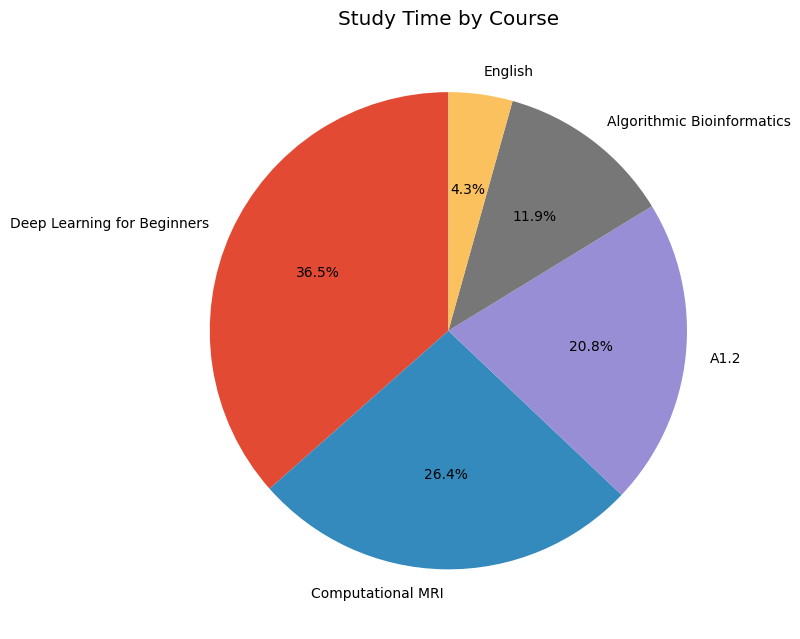

In [4]:
# Aggregate total study hours per course
course_hours = df.groupby("Project name")["Duration_hours"].sum().sort_values(ascending=False)

# Plot pie chart
plt.figure(figsize=(8, 8))
course_hours.plot(
    kind="pie", autopct="%1.1f%%", startangle=90, title="Study Time by Course"
)
plt.ylabel("")
plt.tight_layout()

# Save pie chart as PNG
import os
report_dir = "study_report"
os.makedirs(report_dir, exist_ok=True)
course_pie_plot_path = os.path.join(report_dir, "study_time_by_course.png")
plt.savefig(course_pie_plot_path)

# Display the figure in the notebook
plt.show()

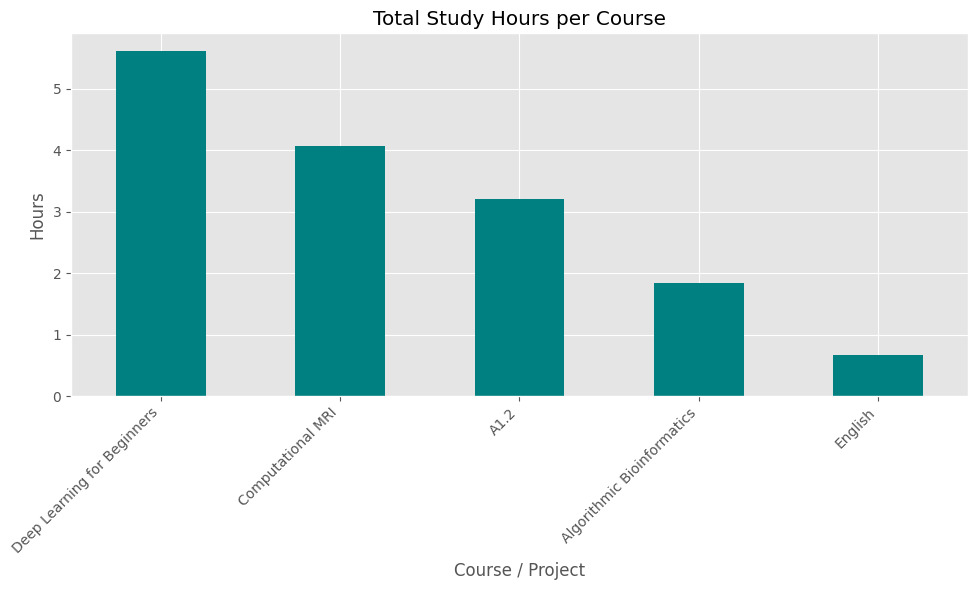

In [5]:
# Bar chart of total study hours per course
course_hours = df.groupby("Project name")["Duration_hours"].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
course_hours.plot(kind="bar", title="Total Study Hours per Course", color='teal')
plt.ylabel("Hours")
plt.xlabel("Course / Project")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# -------------------------------
# Save bar chart as PNG for report
# -------------------------------
import os
report_dir = "study_report"
os.makedirs(report_dir, exist_ok=True)
course_bar_plot_path = os.path.join(report_dir, "total_study_hours_bar.png")
plt.savefig(course_bar_plot_path)

# Display in notebook
plt.show()

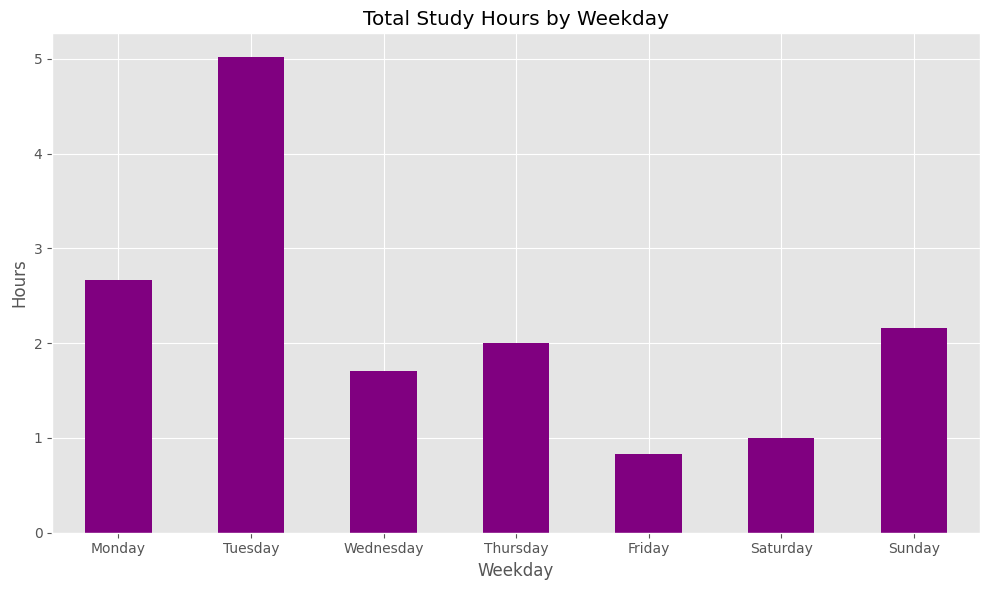

In [6]:
# Aggregate total study hours by weekday
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_hours = df.groupby("Weekday")["Duration_hours"].sum().reindex(weekday_order).fillna(0)

plt.figure(figsize=(10, 6))
weekday_hours.plot(kind="bar", title="Total Study Hours by Weekday", color='purple')
plt.ylabel("Hours")
plt.xlabel("Weekday")
plt.xticks(rotation=0)
plt.tight_layout()

# -------------------------------
# Save bar chart as PNG for report
# -------------------------------
import os
report_dir = "study_report"
os.makedirs(report_dir, exist_ok=True)
weekday_bar_plot_path = os.path.join(report_dir, "study_hours_by_weekday.png")
plt.savefig(weekday_bar_plot_path)

# Display in notebook
plt.show()

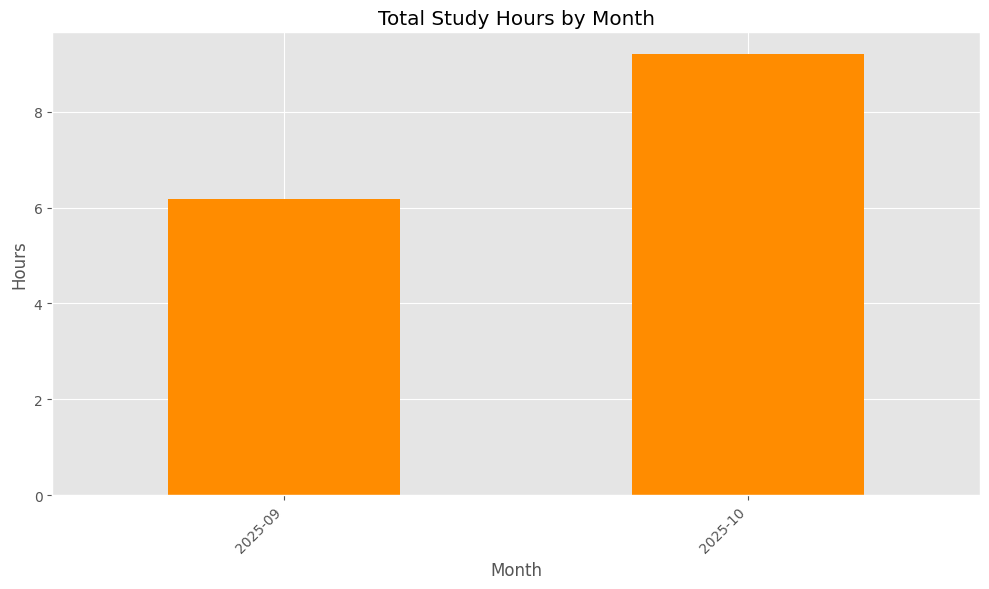

In [7]:
# Aggregate total study hours by month
monthly_hours = df.groupby("Month")["Duration_hours"].sum()

plt.figure(figsize=(10, 6))
monthly_hours.plot(kind="bar", title="Total Study Hours by Month", color='darkorange')
plt.ylabel("Hours")
plt.xlabel("Month")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# -------------------------------
# Save bar chart as PNG for report
# -------------------------------
import os
report_dir = "study_report"
os.makedirs(report_dir, exist_ok=True)
monthly_bar_plot_path = os.path.join(report_dir, "study_hours_by_month.png")
plt.savefig(monthly_bar_plot_path)

# Display in notebook
plt.show()

In [8]:
# Average session duration (in hours)
average_duration = df["Duration_hours"].mean()
print(f"Average session duration: {average_duration:.2f} hours")

# Longest session ever
longest_duration = df["Duration_hours"].max()
longest_session = df.loc[df["Duration_hours"].idxmax()]
print(f"Longest session duration: {longest_duration:.2f} hours")
print("Details of longest session:")
print(longest_session)

# -------------------------------
# Save summary as Markdown for report
# -------------------------------
import os
report_dir = "study_report"
os.makedirs(report_dir, exist_ok=True)
session_summary_md_path = os.path.join(report_dir, "session_summary.md")

with open(session_summary_md_path, "w") as f:
    f.write("## Average Session and Longest Session\n\n")
    f.write(f"- **Average Session Duration:** {average_duration:.2f} hours\n")
    f.write(f"- **Longest Session Duration:** {longest_duration:.2f} hours\n")
    f.write(f"- **Details of Longest Session:**\n\n")
    # Convert the row to Markdown table
    longest_session_df = longest_session.to_frame().T
    f.write(longest_session_df.to_markdown(index=False))
    f.write("\n")

Average session duration: 1.03 hours
Longest session duration: 3.52 hours
Details of longest session:
Project name        Deep Learning for Beginners
Task name                                   NaN
Date                        2025-09-30 00:00:00
Start time                           6:30:32 pm
End time                            10:01:35 pm
Duration                               03:31:03
Time zone                                +02:00
Project archived                          False
Task completed                              NaN
Duration_hours                           3.5175
Weekday                                 Tuesday
Month                                   2025-09
Name: 2, dtype: object


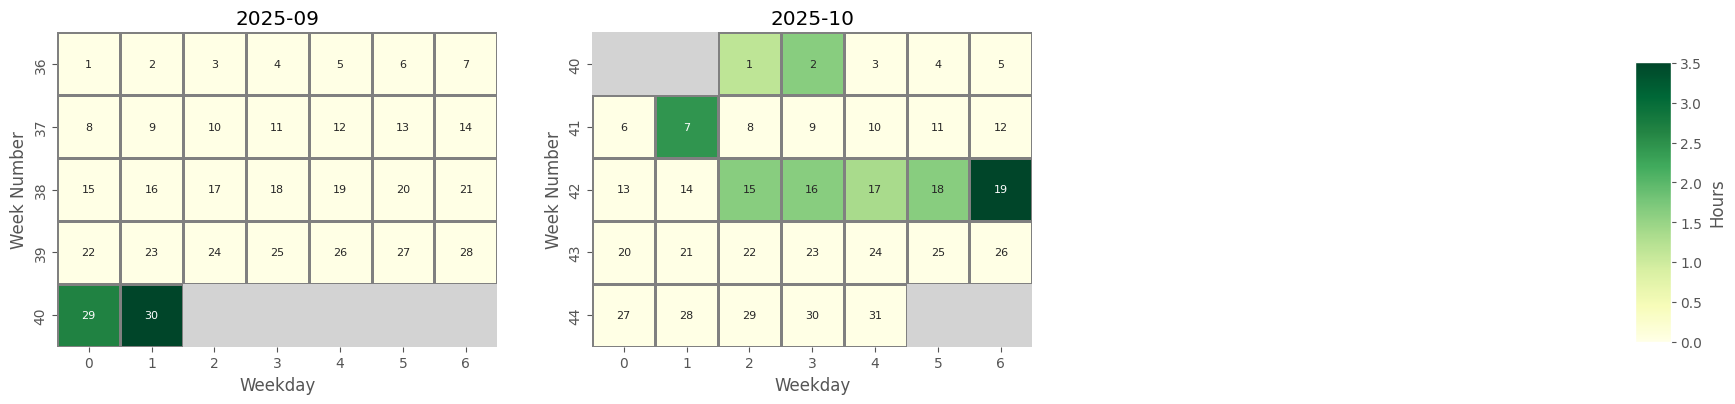

In [9]:
months = sorted(df["Date"].dt.to_period("M").astype(str).unique())
num_months = len(months)
cols = 3
rows = math.ceil(num_months / cols)

report_dir = "study_report"
os.makedirs(report_dir, exist_ok=True)

for r in range(rows):
    fig, axes = plt.subplots(1, cols, figsize=(18, 4))
    axes = axes.flatten()
    
    for c in range(cols):
        i = r * cols + c
        if i >= num_months:
            fig.delaxes(axes[c])
            continue
        
        month = months[i]
        month_data = df.groupby("Date")["Duration_hours"].sum().reset_index()
        month_data = month_data[month_data["Date"].dt.to_period("M").astype(str) == month]

        month_start = month_data["Date"].min().replace(day=1)
        month_end = month_data["Date"].max().replace(day=1) + pd.offsets.MonthEnd(1)
        all_days = pd.DataFrame({"Date": pd.date_range(month_start, month_end)})

        month_data = all_days.merge(month_data, on="Date", how="left").fillna(0)
        month_data["Week"] = month_data["Date"].dt.isocalendar().week
        month_data["Weekday"] = month_data["Date"].dt.weekday
        month_data["Day"] = month_data["Date"].dt.day

        heatmap_data = month_data.pivot(index="Week", columns="Weekday", values="Duration_hours").fillna(0)
        day_labels = month_data.pivot(index="Week", columns="Weekday", values="Day").fillna(0)
        mask = day_labels == 0

        sns.heatmap(
            heatmap_data, cmap="YlGn", linewidths=1, linecolor="gray",
            cbar=False, ax=axes[c], annot=day_labels.astype(int), fmt="d", annot_kws={"fontsize":8},
            mask=mask, square=True
        )

        for y in range(mask.shape[0]):
            for x in range(mask.shape[1]):
                if mask.iloc[y, x]:
                    axes[c].add_patch(plt.Rectangle((x, y), 1, 1, color='lightgray', lw=0))

        axes[c].set_title(f"{month}")
        axes[c].set_xlabel("Weekday")
        axes[c].set_ylabel("Week Number")

    # Single colorbar per row
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.cm.ScalarMappable(cmap="YlGn", norm=plt.Normalize(vmin=0, vmax=df["Duration_hours"].max()))
    fig.colorbar(norm, cax=cbar_ax, label="Hours")

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # -------------------------------
    # Save this row of heatmaps as PNG
    # -------------------------------
    heatmap_row_path = os.path.join(report_dir, f"monthly_heatmaps_row_{r+1}.png")
    plt.savefig(heatmap_row_path)

    # Display in notebook
    plt.show()

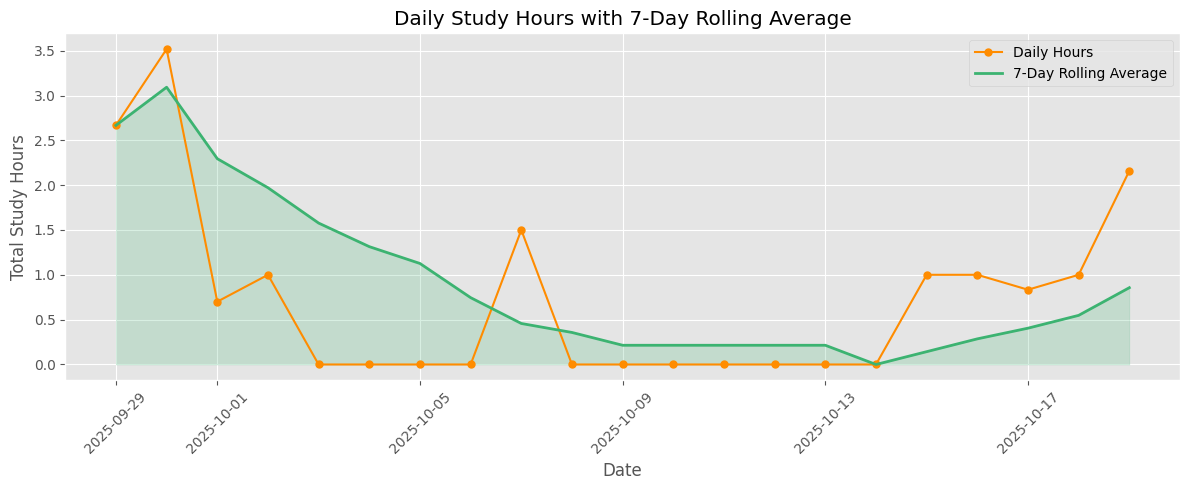

In [10]:
# Aggregate total study hours per day (including zeros)
all_dates = pd.DataFrame({"Date": pd.date_range(df["Date"].min(), df["Date"].max())})
daily_hours = df.groupby("Date")["Duration_hours"].sum().reset_index()
daily_hours = all_dates.merge(daily_hours, on="Date", how="left").fillna(0)

# Calculate 7-day rolling average
daily_hours["Rolling_Avg"] = daily_hours["Duration_hours"].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12, 5))
plt.plot(
    daily_hours["Date"], daily_hours["Duration_hours"],
    marker="o", linestyle="-", color="darkorange", linewidth=1.5, markersize=5,
    label="Daily Hours"
)
plt.plot(
    daily_hours["Date"], daily_hours["Rolling_Avg"],
    linestyle="-", color="mediumseagreen", linewidth=2, label="7-Day Rolling Average"
)
plt.fill_between(daily_hours["Date"], daily_hours["Rolling_Avg"], color="mediumseagreen", alpha=0.2)
plt.xlabel("Date")
plt.ylabel("Total Study Hours")
plt.title("Daily Study Hours with 7-Day Rolling Average")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# -------------------------------
# Save line chart as PNG for report
# -------------------------------
import os
report_dir = "study_report"
os.makedirs(report_dir, exist_ok=True)
daily_hours_plot_path = os.path.join(report_dir, "daily_hours_line_chart.png")
plt.savefig(daily_hours_plot_path)

# Display in notebook
plt.show()

In [11]:
import os

report_dir = "study_report"
os.makedirs(report_dir, exist_ok=True)
md_path = os.path.join(report_dir, "study_report.md")

with open(md_path, "w", encoding="utf-8") as f:
    f.write("# Study Analytics Report\n\n")
    
    # Overall Study Metrics
    f.write("## Overall Study Metrics\n\n")
    f.write("This section summarizes your overall study activity, including total hours, daily average (including days with no study), and the day with the most study hours.\n\n")
    f.write(f"- **Total Sum of All Study Hours:** {total_study_hours:.2f} hours  \n")
    f.write(f"- **Daily Average Study Hours (including zero days):** {daily_average_hours:.2f} hours  \n")
    f.write(f"- **Day with Most Study Time:** {max_date} ({max_weekday}) — {max_hours:.2f} hours\n\n")
    
    # Average and Longest Session
    f.write("## Average and Longest Study Session\n\n")
    f.write("This section provides insight into the duration of your study sessions. It shows your average session length and highlights your longest single study session, along with all details.\n\n")
    f.write(f"- **Average Session Duration:** {average_duration:.2f} hours  \n")
    f.write(f"- **Longest Session Duration:** {longest_duration:.2f} hours  \n")
    f.write("**Details of the longest session:**\n\n")
    f.write(longest_session.to_frame().to_markdown())
    f.write("\n\n")
    
    # Total Study Hours per Course
    f.write("## Total Study Hours per Course\n\n")
    f.write("This table shows the total hours you have spent on each course or project, sorted in descending order. It helps identify which subjects received the most study time.\n\n")
    f.write(course_hours.reset_index(drop=True).to_markdown(index=False))
    f.write("\n\n")
    
    # Plots
    f.write("## Study Time Distribution Plots\n\n")
    plot_descriptions = {
        "study_time_by_course.png": "Pie chart showing the proportion of total study hours spent on each course/project.",
        "total_study_hours_bar.png": "Bar chart of total study hours per course/project, highlighting which courses you studied the most.",
        "study_hours_by_weekday.png": "Bar chart showing your total study hours by weekday, helping you identify patterns in your weekly study routine.",
        "study_hours_by_month.png": "Bar chart displaying the total study hours for each month, giving an overview of monthly study trends.",
        "daily_hours_line_chart.png": "Line chart showing daily study hours with a 7-day rolling average, illustrating trends and consistency over time."
    }
    
    for plot_file, description in plot_descriptions.items():
        img_path = os.path.join(report_dir, plot_file)
        if os.path.exists(img_path):
            f.write(f"### {plot_file.replace('_', ' ').replace('.png', '').title()}\n\n")
            f.write(f"{description}\n\n")
            f.write(f"![{plot_file}]({img_path})\n\n")
    
    # Monthly Heatmaps
    f.write("## Monthly Study Heatmaps\n\n")
    f.write("These heatmaps visualize your daily study hours for each month, similar to GitHub contribution charts. Darker cells represent longer study times, and empty/gray cells indicate days outside the month.\n\n")
    heatmap_files = sorted([f for f in os.listdir(report_dir) if f.startswith("monthly_heatmaps_row_")])
    for heatmap_file in heatmap_files:
        img_path = os.path.join(report_dir, heatmap_file)
        f.write(f"![{heatmap_file}]({img_path})\n\n")

print(f"Markdown report generated with descriptions: {md_path}")

Markdown report generated with descriptions: study_report/study_report.md
